##추출적 요약(Extractive Summarization)

핵심적인 문장을 꺼내와서 요약문을 만드는 방식. 문장들간 연결이 자연스럽지 않다. 
딥 러닝보다는 주로 전통적인 머신 러닝 방식에 속하는 "텍스트 랭크(TextRank)"와 같은 알고리즘을 사용해서 이 방법을 사용한다.

원문을 구성하는 문장 중 어느 것이 요약문에 들어갈 핵심문장인지를 판별한다는 점에서 문장 분류(Text Classification) 문제로 볼 수 있을 것이다.

네어버 뉴스의 요약봇

##추상적 요약(Abstractive Summarization)

원문으로부터 내용이 요약된 새로운 문장을 생성
자연어 처리 분야 중 자연어 생성(Natural Language Generation, NLG)의 영역

**아마존 리뷰 데이터셋**
 ln -s ~/data/*.csv ~/aiffel/news_summarization/data
 
 Id	ProductId	UserId	ProfileName	HelpfulnessNumerator	HelpfulnessDenominator	Score	Time	Summary	Text

**NLTK 불용어**
NLTK는 Natural Language Toolkit의 축약어로 영어 기호, 통계, 자연어 처리를 위한 라이브러리
NLTK에는 I, my, me, over, 조사, 접미사와 같이 문장에는 자주 등장하지만, 의미를 분석하고 요약하는 데는 거의 의미가 없는 100여개의 불용어가 미리 정리되어 있음

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print('=3')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


=3


In [2]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 198
['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "

## 아마존 뉴스 요약 데이터셋 가져오기

In [3]:
# 링크에서 다운로드 받은 데이터(Reviews.csv)는 총 568,454개의 샘플을 갖고 있어요. 
# 시간상 여기서는 모든 샘플을 사용하지는 않고, 간단히 10만 개의 샘플만 사용해볼게요
data = pd.read_csv(os.getenv("HOME")+"/aiffel/news_summarization/data/Reviews.csv", nrows=100000)
print('전체 샘플수 :', (len(data)))

print(type(data))

data.head()

전체 샘플수 : 100000
<class 'pandas.core.frame.DataFrame'>


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
# 'Summary'와 'Text' 열만 가져오기
data = data[['Summary', 'Text']]
data.head()

,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,"""Delight"" says it all",This is a confection that has been around a fe...
3,Cough Medicine,If you are looking for the secret ingredient i...
4,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 88426
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 72348


**중복제거**

In [6]:
# 데이터프레임의 drop_duplicates()를 사용하면, 손쉽게 중복 샘플을 제거

# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['Text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88426


**Null값확인**

In [7]:
print(data.isnull().sum())

data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

Summary    1
Text       0
dtype: int64
전체 샘플수 : 88425


**텍스트 정규화(text normalization)**

In [8]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [9]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')



=3


In [10]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary: great way to start the day


In [11]:
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
clean_text = []

clean_text = data['Text'].apply(lambda x: preprocess_sentence(str(x), remove_stopwords=True))

#for t in data['Text']:
#   clean_text.append(preprocess_sentence(t, True))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  0    bought several vitality canned dog food produc...
1    product arrived labeled jumbo salted peanuts p...
2    confection around centuries light pillowy citr...
3    looking secret ingredient robitussin believe f...
4    great taffy great price wide assortment yummy ...
Name: Text, dtype: object


In [ ]:
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
clean_summary = []

clean_summary = data['Summary'].apply(lambda x: preprocess_sentence(str(x), remove_stopwords=False))

print("Summary 전처리 후 결과: ", clean_summary[:5])

In [13]:
data['Text'] = clean_text
data['Summary'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
data.isnull().sum()

data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 88355


**샘플의 최대 길이 정하기**

텍스트의 최소 길이 : 2
텍스트의 최대 길이 : 1235
텍스트의 평균 길이 : 38.792428272310566
요약의 최소 길이 : 1
요약의 최대 길이 : 28
요약의 평균 길이 : 4.010729443721352


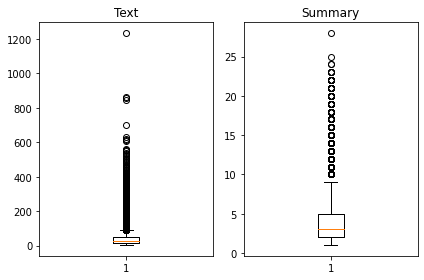

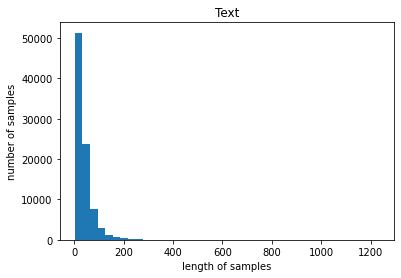

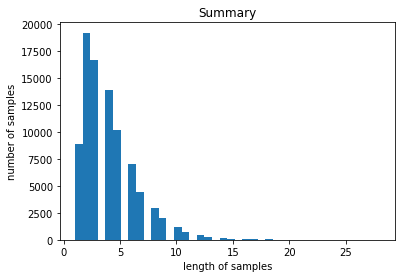

In [14]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(str.split()) for str in data['Text']]
summary_len = [len(str.split()) for str in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [16]:
text_max_len = 50
summary_max_len = 8

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len,  data['Summary'])

=3
전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.7745119121724859
전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.9424593967517402


In [17]:
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]

In [18]:
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 65818


**시작 토큰과 종료 토큰 추가하기**

In [19]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Summary,Text,decoder_input,decoder_target
0,good quality dog food,bought several vitality canned dog food produc...,sostoken good quality dog food,good quality dog food eostoken
1,not as advertised,product arrived labeled jumbo salted peanuts p...,sostoken not as advertised,not as advertised eostoken
2,delight says it all,confection around centuries light pillowy citr...,sostoken delight says it all,delight says it all eostoken
3,cough medicine,looking secret ingredient robitussin believe f...,sostoken cough medicine,cough medicine eostoken
4,great taffy,great taffy great price wide assortment yummy ...,sostoken great taffy,great taffy eostoken


**훈련데이타와 테스트데이터 나누기**

In [20]:
#인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장

encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력 (sostoken ~)
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블 (~ eostoken)
print('=3')

=3


In [21]:
# 인코더 입력과 같은 크기와 형태의 정수 시퀀스
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[52694 56022 17565 ... 62726 45859 60140]


In [22]:
# 샘플을 섞어준다

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

=3


In [23]:
# 이제 섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 13163


In [24]:
# 테스트 데이터의 개수를 이용해 전체 데이터를 양분
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 52655
훈련 레이블의 개수 : 52655
테스트 데이터의 개수 : 13163
테스트 레이블의 개수 : 13163


**단어 집합(vocabulary) 만들기 및 정수 인코딩**

    Tokenizer()
    * fit_on_texts(texts)	전체 텍스트 데이터에 대해 단어 사전 구축
    * texts_to_sequences(texts)	텍스트를 정수 시퀀스로 변환
    * sequences_to_texts(sequences)	시퀀스를 다시 텍스트로 복원
    * texts_to_matrix(texts, mode='binary')	텍스트를 벡터화 (BoW, TF-IDF 등 지원)
    * word_index	단어와 정수 인덱스의 매핑 딕셔너리
    * index_word	인덱스 → 단어 매핑 (역변환)

In [25]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

# src_tokenizer.word_index에 단어집합이 생성되어 있음

In [27]:
print('src_tokenizer.word_index :', len(src_tokenizer.word_index))

src_tokenizer.word_index : 32005


    tokenizer.word_counts
    
    * OrderedDict 형태
    * 단어를 키(key)로, 등장 횟수를 값(value)으로 가짐
    * fit_on_texts() 실행 후에 생성됨

In [30]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 32005
등장 빈도가 6번 이하인 희귀 단어의 수: 23757
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 8248
단어 집합에서 희귀 단어의 비율: 74.22902671457585
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.393971024699432


In [33]:
# total_cnt - rare_cnt 수로 단어 집합을 제한
# num_words	사용할 단어의 최대 개수 (빈도순 정렬 후 상위 n개만 사용)

src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('src_tokenizer.word_index :', len(src_tokenizer.word_index))

src_tokenizer.word_index : 32005


In [34]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[124, 213, 7, 82, 100, 189, 56, 233, 33, 504, 209, 548, 141, 558, 159, 133, 121, 1831, 42, 55, 25], [50, 2821, 136, 2102, 75, 24, 386, 274, 313, 719, 176, 1020, 205, 36, 139, 45, 614, 5664, 807, 2399, 131, 1892, 2822, 563, 171, 292, 1147, 536, 30, 112, 616], [49, 1501, 1359, 2028, 134, 2860, 683, 3, 509]]


In [35]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')

=3


In [36]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 10553
등장 빈도가 5번 이하인 희귀 단어의 수: 8163
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 2390
단어 집합에서 희귀 단어의 비율: 77.35241163650147
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.914462989871638


In [37]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 65, 65, 4], [1, 47, 64, 654, 8, 1955], [1, 1555, 1556], [1, 3, 27, 21, 3, 48, 948], [1, 3, 8, 1451, 1790, 22, 1159]]
target
decoder  [[65, 65, 4, 2], [47, 64, 654, 8, 1955, 2], [1555, 1556, 2], [3, 27, 21, 3, 48, 948, 2], [3, 8, 1451, 1790, 22, 1159, 2]]


요약문에서 길이가 0이 된 샘플들의 인덱스를 받아와볼게요. 여기서 주의할 점은 요약문인 decoder_input에는 sostoken 또는 decoder_target에는 eostoken이 추가된 상태이고, 이 두 토큰은 모든 샘플에서 등장하므로 빈도수가 샘플 수와 동일하게 매우 높으므로 단어 집합 제한에도 삭제되지 않아요. 그래서 이제 길이가 0이 된 요약문의 실제 길이는 1로 나올 거예요. 길이 0이 된 decoder_input에는 sostoken, decoder_target에는 eostoken만 남아 있을 테니까요.

In [38]:
# sostoken만 있는 decoder_input
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

# summary가 없으면, text(encoder)도 없어야 한다. 
encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1294
삭제할 테스트 데이터의 개수 : 318
훈련 데이터의 개수 : 51361
훈련 레이블의 개수 : 51361
테스트 데이터의 개수 : 12845
테스트 레이블의 개수 : 12845


**패딩하기**

In [39]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')

decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')
print('=3')

=3


**인코더와 디코더 모델 설계**

In [52]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))  # text_max_len로 크기 정해줌

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1   
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

In [53]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)
#dec_emb = Embedding(tgt_vocab, embedding_dim)(decoder_inputs)

# 디코더의 LSTM
# 인코더의 hidden state와 cell state가 디코더의 초기 state로 사용.
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [54]:
# 디코더의 출력층
# 디코더 출력층은 Summary의 단어장인 tar_vocab의 수많은 선택지 중 하나의 단어를 선택하는 다중 클래스 분류 문제
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) # decoder output만 사용

# 모델 정의
# input : encoder_input, decoder_input 
# output : decoder_softmax_outputs
model_seq2seq = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model_seq2seq.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 50, 128)      1024000     input_10[0][0]                   
__________________________________________________________________________________________________
lstm_17 (LSTM)                  [(None, 50, 256), (N 394240      embedding_9[0][0]                
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, None)]       0                                            
____________________________________________________________________________________________

**어텐션 메커니즘**

In [55]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])


# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)  # 인코더와 concat한 결과를 사용

# 모델 정의
model_attention = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model_attention .summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 50, 128)      1024000     input_10[0][0]                   
__________________________________________________________________________________________________
lstm_17 (LSTM)                  [(None, 50, 256), (N 394240      embedding_9[0][0]                
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, None)]       0                                            
____________________________________________________________________________________________

In [56]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
201/201 [==============================] - 19s 63ms/step - loss: 2.7300 - val_loss: 2.4528
Epoch 2/50
201/201 [==============================] - 12s 58ms/step - loss: 2.4189 - val_loss: 2.3456
Epoch 3/50
201/201 [==============================] - 12s 58ms/step - loss: 2.3045 - val_loss: 2.2422
Epoch 4/50
201/201 [==============================] - 12s 59ms/step - loss: 2.2028 - val_loss: 2.1587
Epoch 5/50
201/201 [==============================] - 12s 60ms/step - loss: 2.1264 - val_loss: 2.0995
Epoch 6/50
201/201 [==============================] - 12s 60ms/step - loss: 2.0682 - val_loss: 2.0593
Epoch 7/50
201/201 [==============================] - 12s 59ms/step - loss: 2.0207 - val_loss: 2.0284
Epoch 8/50
201/201 [==============================] - 12s 59ms/step - loss: 1.9849 - val_loss: 1.9993
Epoch 9/50
201/201 [==============================] - 12s 59ms/step - loss: 1.9431 - val_loss: 1.9786
Epoch 10/50
201/201 [==============================] - 12s 59ms/step - loss: 1.905

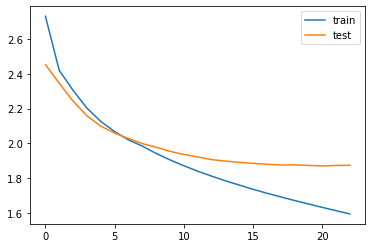

In [57]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 추론 모델 구현하기 (인퍼런스 inference )

훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한 번에 비교할 수 있으므로, 인코더와 디코더를 엮은 통짜 모델 하나만 준비했습니다.

그러나 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야 합니다. 이때는 인코더 모델과 디코더 모델을 분리해서 설계합니다

In [58]:
# 테스트 단계에서는 word_to_index가 필요함 

src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


In [59]:
# 인코더 설계
# input : encoder_input
# output : last lstm layer 의 state_h, state_c
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])


# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 
# 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')

=3


In [60]:

# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
# 디코더의 output과 hidden satte를 어텐션층에 전달하고 결과를 리턴
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
# input : decoder inputs, atteion_hidden_state, decoder_old_state_h & c, 
# output : decoder output, decoder_out_h_state, decoder_out_c_state
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


In [61]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


In [63]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if( i==0):
            continue
        if(tar_index_to_word[i] == 'eostoken') :
            break
        temp = temp + tar_index_to_word[i]+' '
    return temp

print('=3')

=3


In [64]:
for i in range(50, 60):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : taste okay really ridiculous amount sugar guess meant appeal masses care things like weight gain diabetes eat bars head 
실제 요약 : sostoken way too much sugar 
예측 요약 :  ever biscuits eh eh enjoying rating cacao


원문 : best product love masala mix looks costly buy local indian store 
실제 요약 : sostoken too 
예측 요약 :  ever mandarin mandarin dog nantucket folgers six


원문 : love aroma coffee perfect crisp autumn mornings price per pound also really yummy buy coffee 
실제 요약 : sostoken yummy and good value 
예측 요약 :  ever mandarin where where where where where


원문 : honestly best green tea tried far tried many different brands tea bags loose leaf teas organic gunpowder however best tasted think actually relaxing would definately order product willing try green teas 
실제 요약 : sostoken excellent tea 
예측 요약 :  texas mellow mellow where where where where


원문 : love green tea good really excited receive assortment nice selection flavors flavors mild like make iced sun tea bags make decent cold te

## 추출절 요약해보기 (summa)

In [65]:
from summa.summarizer import summarize
import os
home = os.getenv('HOME')
path = os.path.join(home, 'aiffel', 'The_matrix_synopsis.txt')
with open(path, encoding = 'UTF-8') as f:
    text = f.read()

In [66]:
print(text[:1500])

(Cellular)
Cypher: Yeah.
Trinity: Is everything in place?
Cypher: You weren't supposed to relieve me.
Trinity: I know, but I want to take your shift.
Cypher: You like watching him, don't you? You like watching him.
Trinity: Don't be ridiculous.
Cypher: We're going to kill him, do you understand that?
Trinity: Morpheus believes he is the one.
Cypher: Do you?
Trinity: It doesn't matter what I believe.
Cypher: You don't, do you?
Trinity: Did you hear that?
Cypher: Hear what?
Trinity: Are you sure this line is clean?
Cypher: Yeah, of course I'm sure.
Trinity: I better go.

(Hotel room)
Cop: Freeze, Police. Hands on your head. Do it. Do it now.

(Street)
Agent Smith: Lieutenant...
Lieutenant: Oh shit.
Agent Smith: Lieutenant, you were given specific orders.
Lieutenant: Hey, I'm just doing my job. You give me juris- my diction crap, you can cram it up your ass.
Agent Smith: Your orders were for your protection.
Lieutenant: I think we can handle one little girl.... I sent two units. They're b

- Summa의 summarize()의 인자로 사용되는 값들
text (str) : 요약할 테스트.
ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값
words (int or None, optional) – 출력에 포함할 단어 수.
만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.
split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환

In [67]:
print('Summary:')
print(summarize(text, ratio=0.05))

Summary:
Neo: What?
Neo: My computer, it...
Neo: Who are you?
Neo: Trinity.
Neo: It you on my computer.
Neo: Of what?
Morpheus: Hello Neo. Do you know who this is?
Neo: Morpheus.
Morpheus: Yes. I've been looking for you, Neo. I don't know if you're ready to see what I want to show you, but unfortunately you and I have run out of time.
Neo: How?
Neo: What if they...
Neo: From what.
Neo: What?
Neo: Why?
Neo: No. Morpheus: Why not?
Neo: You did all this?
Neo: Did you...
Neo: This can't be...
Neo: What are you doing.
Neo: When?
Neo: I can't go back, can I?
Neo: For what?
Neo: You don't...you don't have any...
Neo: Where is it?
Neo: I was...
Neo: What are they?
Neo: Someone?
Neo: Why?
Neo: Where are we?
Neo: Is that...
Neo: Of who?
Neo: See who?
Neo: Did you go to her?
Neo: What?
Neo: Who?
Neo: But what?
Neo: What?
Neo: Morpheus.
Neo: What?
Neo: What is it?
Morpheus: You must get Neo out.
Neo: No. No, Morpheus.
Trinity: You first, Neo.
Neo: You first.
Neo: What are they doing to him.
Neo: T

In [68]:
print('Summary:')
print(summarize(text, ratio=0.005, split=True))

Summary:
['Neo: Morpheus.', 'Neo: No. Morpheus: Why not?', 'Neo: Morpheus.', 'Neo: No. No, Morpheus.', 'Neo: Morpheus, get up.', 'Neo: Morpheus.']


In [69]:
print('Summary:')
print(summarize(text, words=50))

Summary:
Neo: Morpheus.
Morpheus: Yes. I've been looking for you, Neo. I don't know if you're ready to see what I want to show you, but unfortunately you and I have run out of time.
Neo: No. Morpheus: Why not?
Neo: Morpheus.
Morpheus: You must get Neo out.
Neo: No. No, Morpheus.
Neo: Morpheus, get up.
Neo: Morpheus.
Neo: You first, Morpheus.
